# SailGP Data Analyst Challenge

The aim is to test you python abilities. The challenge is to analyze the data provided and answer the questions below. You can use any library you want to help you with the analysis. The data is from the SailGP event in Auckland 2025. The data is in the 'DATA' folder.

There are various sources available.

The Boat Logs are in the 'Boat_Logs' folder. The data is in csv format and the columns are described in the 'Boat_Logs/Boat_Logs_Columns.csv' file.
The 'Course_Marks_2025-01-19.csv' file contains the mark positions and wind reading on the course for the whole day.

The Race_XML folder contains the xml files for each race that contains information on where the boundaries of the course are, the theoretical position of the marks and the target racecourse axis.

The 2025-01-19_man_summary.csv file contains the metrics from the manoeuvre summary for the day.
The 2025-01-19_straight_lines.csv file contains the metrics from the straight line summary for the day.

Both are derived from the boat logs.

The 2502 m8_APW_HSB2_HSRW.kph.csv file contains the polar data for the boats in that config.

## Requierements
- Chose at least 3 questions from the list below to answer.
- Python 3.8 or higher
- Notebook should be able to run without any errors from start to finish.
- Specify the libraries (imports) used in the notebook.
- Any comments to make the notebook self-explanatory and easy to follow would be appreciated.
- If you can't get to the end of a question, we would appreciate the code you have written so far and explain what you were trying to do.

## Further information:
- We usually use bokeh for visualizations. So any showcase of bokeh would be appreciated.
-

## Submitting the results.
It would be great if you could provide a jupyter notebook with the code and the results of the analysis. You can submit the results by sharing a link to a git repository.


### Imports and re-used functions
Free section to initialize the notebook with the necessary imports and functions that will be used in the notebook.



In [12]:
import pandas as pd, numpy as np
from math import radians, degrees, sin, cos, atan2, sqrt

## Question 1: Write a Python function that can take a compass direction (ie. TWD or Heading) and calculate an accurate mean value across a downsampled frequency. Eg. If TWD is at 1Hz, give me a 10s average.

There are two main parts to this question. First I have made a function to calculate a circular mean so that it doesn't get stuck with headings that oscillate either side of North. The next part is to create a mean of these numbers on a down-sampled range. I have chosen to average the whole of the bin (that can be specified) directly before that time point and include that time point. For 10 seconds you would get the everything from the previous 9 seconds and the current second. This enables the function to be usable in a live scenario if needed as it doesn't use future data, and seemed the most logical approach. 

In [13]:
def circular_mean_deg(series: pd.Series) -> float:
    """
    Calculate circular mean of angles in degrees (0-360), ignoring NaNs.
    
    Uses vector averaging to properly handle the wraparound nature of angles
    (e.g., averaging 359° and 1° gives 0°, not 180°).
    
    Parameters
    ----------
    series : pd.Series
        Series of angles in degrees (0-360)
        
    Returns
    -------
    float
        Circular mean in degrees (0-360), or NaN if input is empty
    """
    x = series.dropna().to_numpy(dtype=float)
    if x.size == 0:
        return np.nan
    
    # Convert degrees to radians
    r = np.deg2rad(x)
    
    # Calculate mean vector components
    s = np.mean(np.sin(r))
    c = np.mean(np.cos(r))
    
    # Convert back to degrees in [0, 360) range
    mean_rad = np.arctan2(s, c)
    return (np.rad2deg(mean_rad) + 360.0) % 360.0


def mean_dir(
    df: pd.DataFrame,
    direction_col: str,
    freq: str = "10S", #10 seconds for default
    time_col: str = "DATETIME",
    label: str = "right",
    closed: str = "right",
) -> pd.DataFrame:
    """
    Downsample a direction column (degrees) using a circular mean over time bins.
    
    The circular mean properly handles the wraparound nature of compass directions
    (e.g., averaging 359° and 1° gives 0°, not 180°).
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with time series data
    direction_col : str
        Column name containing compass directions in degrees (0-360)
    freq : str, default "10S"
        Resample frequency (e.g., '10S', '1min', '5min')
        Pandas frequency string format
    time_col : str, default "DATETIME"
        Name of the datetime column to use for resampling
    label : str, default "right"
        Which bin edge to label the bin with ('left' or 'right')
    closed : str, default "right"
        Which side of bin interval is closed ('left' or 'right')
    
    Returns
    -------
    pd.DataFrame
        Dataframe with datetime index and one column containing the circular mean
        Column name format: "{direction_col}_mean_{freq}"
    """
    out_col = f"{direction_col}_mean_{freq}"
    
    # Copy and prepare data
    d = df.copy()
    d[time_col] = pd.to_datetime(d[time_col], errors="coerce")
    d = d.dropna(subset=[time_col]).sort_values(time_col).set_index(time_col)
    
    # Resample and apply circular mean
    out = (
        d[direction_col]
        .resample(freq, label=label, closed=closed)
        .apply(circular_mean_deg)
        .to_frame(name=out_col)
        .dropna()
    )
    
    return out


# Example usage
df = pd.read_csv("Data/Boat_logs/data_AUS.csv")

# 10-second mean for True Wind Direction
twd_10s = mean_dir(df, direction_col="TWD_SGP_deg", freq="10S")

print(twd_10s.head())

                     TWD_SGP_deg_mean_10S
DATETIME                                 
2025-01-19 02:56:10             66.960000
2025-01-19 03:06:00             53.630000
2025-01-19 03:06:10             57.656156
2025-01-19 03:06:20             56.216362
2025-01-19 03:06:30             45.781740


## Question 2: Given a course XML and a timeseries of boat Lat/Lon values, calculate a VMC column for the same timeseries.


For this question I used the timeseries of boat Lat/Lon values to calculate the boats' course over ground as well as the boat speed. I am aware SOG has been recorded in the data_BOAT.csv but my interpretation of the question was to not use that. Although distances are small, for the sake of increased accuracy I chose to us the Haversine formula to calculate distance between Lat/Lon points. When calculating VMC to a gate mark I have assumed using the midpoint between the two marks is acceptable.

I have calculated SOG using change in distance between consecutive boat positions, and COG in a similar manner using boat angle. Using these along with the mark position, I have calculated the VMC as VMC = SOG * cos(angle between COG and bearing to next mark)

In [14]:
from bs4 import BeautifulSoup
from math import radians, degrees, sin, cos, atan2, sqrt


def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great-circle distance between two points in meters.
    """
    R = 6371000  # Earth's radius in meters
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return R * c


def compute_bearing(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the bearing from point 1 to point 2.
    Returns bearing in degrees (0-360).
    """
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    x = sin(dlon) * cos(lat2)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dlon)
    
    bearing = degrees(atan2(x, y))
    return (bearing + 360) % 360


def calculate_sog_cog(
    df: pd.DataFrame,
    lat_col: str = 'LATITUDE_GPS_unk',
    lon_col: str = 'LONGITUDE_GPS_unk',
    time_col: str = 'DATETIME',
) -> pd.DataFrame:
    """
    Calculate Speed Over Ground (SOG) and Course Over Ground (COG) from lat/lon timeseries.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with latitude, longitude, and datetime columns
    lat_col : str
        Column name for latitude
    lon_col : str
        Column name for longitude  
    time_col : str
        Column name for datetime
        
    Returns
    -------
    pd.DataFrame
        Original dataframe with added columns:
        - SOG_calc_km_h: speed over ground in km/h
        - COG_calc_deg: course over ground in degrees (0-360)
        
    Note: First row will have NaN values since we need two points to calculate.
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(time_col).reset_index(drop=True)
    
    lats = df[lat_col].values
    lons = df[lon_col].values
    times = df[time_col].values
    
    sog = np.full(len(df), np.nan)
    cog = np.full(len(df), np.nan)
    
    for i in range(1, len(df)):
        # Distance in meters
        dist = haversine_distance(lats[i-1], lons[i-1], lats[i], lons[i])
        
        # Time difference in seconds
        dt = (times[i] - times[i-1]) / np.timedelta64(1, 's')
        
        if dt > 0:
            # Speed: m/s -> km/h (multiply by 3.6)
            sog[i] = (dist / dt) * 3.6
            
            # Course over ground
            cog[i] = compute_bearing(lats[i-1], lons[i-1], lats[i], lons[i])
    
    df['SOG_calc_km_h'] = sog
    df['COG_calc_deg'] = cog
    
    return df


def parse_course_xml(xml_path: str) -> pd.DataFrame:
    """
    Parse a race XML file and return the mark sequence with target coordinates.
    
    Uses BeautifulSoup for XML parsing. For gates (2 marks), returns the 
    midpoint between the two marks.
    
    Returns
    -------
    pd.DataFrame
        Columns: seq_id, compound_mark_id, name, target_lat, target_lon
    """
    with open(xml_path, 'r') as f:
        soup = BeautifulSoup(f, 'xml')
    
    # Build lookup of CompoundMarkID -> mark info
    compound_marks = {}
    for cm in soup.find_all('CompoundMark'):
        cm_id = int(cm['CompoundMarkID'])
        marks = cm.find_all('Mark')
        
        # Calculate centroid for gates with multiple marks
        lats = [float(m['TargetLat']) for m in marks]
        lons = [float(m['TargetLng']) for m in marks]
        
        compound_marks[cm_id] = {
            'name': cm['Name'],
            'target_lat': np.mean(lats),
            'target_lon': np.mean(lons),
        }
    
    # Build sequence from CompoundMarkSequence
    sequence = []
    for corner in soup.find('CompoundMarkSequence').find_all('Corner'):
        seq_id = int(corner['SeqID'])
        cm_id = int(corner['CompoundMarkID'])
        cm = compound_marks[cm_id]
        sequence.append({
            'seq_id': seq_id,
            'compound_mark_id': cm_id,
            'name': cm['name'],
            'target_lat': cm['target_lat'],
            'target_lon': cm['target_lon'],
        })
    
    return pd.DataFrame(sequence)


def calculate_vmc(
    df: pd.DataFrame,
    course_df: pd.DataFrame,
    lat_col: str = 'LATITUDE_GPS_unk',
    lon_col: str = 'LONGITUDE_GPS_unk',
    sog_col: str = 'SOG_calc_km_h',
    cog_col: str = 'COG_calc_deg',
    leg_col: str = 'TRK_LEG_NUM_unk',
) -> pd.DataFrame:
    """
    Calculate VMC (Velocity Made good to Course mark) for each row.
    
    VMC = SOG * cos(angle between COG and bearing to next mark)
    
    Parameters
    ----------
    df : pd.DataFrame
        Boat log data with SOG and COG columns (from calculate_sog_cog)
    course_df : pd.DataFrame  
        Course marks from parse_course_xml()
    
    Returns
    -------
    pd.DataFrame
        Original dataframe with added columns:
        - target_mark: name of the target mark
        - bearing_to_mark: bearing from boat to target mark (degrees)
        - VMC_calc_km_h: velocity made good to course mark (km/h)
    """
    df = df.copy()
    
    # Create leg -> next mark mapping
    mark_lookup = course_df.set_index('seq_id')[['name', 'target_lat', 'target_lon']]
    
    target_marks = []
    bearings = []
    vmcs = []
    
    for _, row in df.iterrows():
        leg = row[leg_col]
        
        # Target mark is leg + 1 (leg 0 = heading to mark 1, etc.)
        target_seq = int(leg) + 1
        
        if target_seq not in mark_lookup.index or pd.isna(row[sog_col]):
            target_marks.append(None)
            bearings.append(np.nan)
            vmcs.append(np.nan)
            continue
        
        mark = mark_lookup.loc[target_seq]
        
        # Bearing from boat to mark
        bearing = compute_bearing(
            row[lat_col], row[lon_col],
            mark['target_lat'], mark['target_lon']
        )
        
        # Angle difference (normalized to -180 to 180)
        angle_diff = bearing - row[cog_col]
        angle_diff = (angle_diff + 180) % 360 - 180
        
        # VMC = SOG * cos(angle_diff)
        vmc = row[sog_col] * cos(radians(angle_diff))
        
        target_marks.append(mark['name'])
        bearings.append(bearing)
        vmcs.append(vmc)
    
    df['target_mark'] = target_marks
    df['bearing_to_mark'] = bearings
    df['VMC_calc_km_h'] = vmcs
    
    return df


# === Example usage ===

# Parse course XML
course = parse_course_xml('Data/Race_XMLs/25011905_03-13-55.xml')
print("Course marks:")
print(course)
print()

# Load boat data
file_path = 'Data/Boat_logs/data_AUS.csv'
df = pd.read_csv(file_path)
boat = file_path.split('_')[-1].split('.')[0]

# Calculate SOG and COG from lat/lon
df = calculate_sog_cog(df)

# Calculate VMC
df = calculate_vmc(df, course)
#print(len(df))

# Show results
print(f"VMC calculation results for {boat}:")
print(df[['DATETIME', 'TRK_LEG_NUM_unk', 'target_mark', 'SOG_calc_km_h', 'COG_calc_deg', 'bearing_to_mark', 'VMC_calc_km_h']].iloc[1030:1040])

Course marks:
   seq_id  compound_mark_id name  target_lat  target_lon
0       1                 1  SL1  -36.834987  174.768660
1       2                 2   M1  -36.829713  174.765270
2       3                 3  LG1  -36.833846  174.754826
3       4                 4  WG1  -36.829794  174.767608
4       5                 5  LG1  -36.833846  174.754826
5       6                 6  WG1  -36.829794  174.767608
6       7                 7  LG1  -36.834715  174.755873
7       8                 8  FL1  -36.835870  174.758561

VMC calculation results for AUS:
                DATETIME  TRK_LEG_NUM_unk target_mark  SOG_calc_km_h  \
1030 2025-01-19 03:33:09              4.0         LG1      80.989978   
1031 2025-01-19 03:33:10              4.0         LG1      81.166039   
1032 2025-01-19 03:33:11              4.0         LG1      81.190453   
1033 2025-01-19 03:33:12              4.0         LG1      81.395809   
1034 2025-01-19 03:33:13              4.0         LG1      81.806310   
1035 20

## Question 3: Verify and comment on the boats calibration. If possible propose a post-calibrated set of wind numbers and a potential calibration table.


I chose to check the TWD for all boats first using a normal distribution to see if there was anything unexpected happening there. I then chose to look into the AWA between the different tacks when the boats were racing. I noticed Canada's data was anomalous compared to the others. This is because they did not complete the first race of that day, hence data from boat Canada is disregarded.

I have added more markdown cells for observations and next steps as I went through the question.

In [15]:
import glob
from scipy import stats
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Category10
from bokeh.models import Legend

output_notebook()

# Load all boat data (filtered to racing data only)
boat_files = glob.glob('Data/Boat_logs/data_*.csv')
all_boats = {}

for f in boat_files:
    boat_name = f.split('_')[-1].replace('.csv', '')
    df = pd.read_csv(f)
    # Filter to racing data only (when boats are on a leg)
    df = df[df['TRK_LEG_NUM_unk'] >= 1]
    all_boats[boat_name] = df

print(f"Loaded {len(all_boats)} boats (racing data only): {list(all_boats.keys())}")


def plot_wind_distributions(all_boats: dict, column: str, title: str, x_label: str):
    """
    Plot normal distribution curves for a wind column across all boats.
    
    Parameters
    ----------
    all_boats : dict
        Dictionary of boat_name -> DataFrame
    column : str
        Column name to plot (e.g., 'TWD_SGP_deg', 'TWA_SGP_deg')
    title : str
        Plot title
    x_label : str
        X-axis label
    """
    p = figure(
        title=title,
        x_axis_label=x_label,
        y_axis_label='Density',
        width=900,
        height=500,
    )
    
    colors = Category10[10] + ('#e377c2',)  # 11 colors for 11 boats
    legend_items = []
    
    for i, (boat_name, df) in enumerate(sorted(all_boats.items())):
        data = df[column].dropna()
        
        if len(data) < 2:
            continue
        
        # Fit normal distribution
        mu, std = stats.norm.fit(data)
        
        # Generate x values for the curve
        x = np.linspace(data.min(), data.max(), 200)
        pdf = stats.norm.pdf(x, mu, std)
        
        # Plot the distribution curve
        line = p.line(x, pdf, line_width=2, color=colors[i % len(colors)], alpha=0.8)
        legend_items.append((f"{boat_name} (μ={mu:.1f}, σ={std:.1f})", [line]))
    
    # Add legend outside the plot
    legend = Legend(items=legend_items, location='top_right')
    legend.click_policy = 'hide'  # Click to toggle visibility
    p.add_layout(legend, 'right')
    
    show(p)


# Just used to initially check if there was anything dodgy with wind readings between the boats. I have chosen to comment this out to limit the number of graphs being shown
# # Plot TWD distribution for all boats
# plot_wind_distributions(
#     all_boats,
#     column='TWD_SGP_deg',
#     title='True Wind Direction (TWD) Distribution by Boat',
#     x_label='TWD (degrees)'
# )

# # Plot TWA distribution for all boats
# plot_wind_distributions(
#     all_boats,
#     column='TWA_SGP_deg',
#     title='True Wind Angle (TWA) Distribution by Boat',
#     x_label='TWA (degrees)'
# )


def plot_awa_by_tack(all_boats: dict, tack: str, max_angle: float = 75.0):
    """
    Plot AWA distributions for a single tack across all boats.
    
    Parameters
    ----------
    all_boats : dict
        Dictionary of boat_name -> DataFrame
    tack : str
        'port' or 'starboard'
    max_angle : float
        Maximum AWA to display on x-axis
    """
    colors = Category10[10] + ('#e377c2',)
    
    title = f'Apparent Wind Angle (AWA) - {tack.capitalize()} Tack'
    
    p = figure(
        title=title,
        x_axis_label='|AWA| (degrees)',
        y_axis_label='Density',
        width=900,
        height=500,
        x_range=(0, max_angle),
    )
    
    legend_items = []
    
    for i, (boat_name, df) in enumerate(sorted(all_boats.items())):
        # Split by tack using TWA sign
        if tack == 'port':
            data = df[df['TWA_SGP_deg'] < 0]['AWA_SGP_deg'].dropna().abs()
        else:
            data = df[df['TWA_SGP_deg'] > 0]['AWA_SGP_deg'].dropna().abs()
        
        # Filter to max_angle
        data = data[data <= max_angle]
        
        if len(data) < 2:
            continue
        
        # Fit distribution
        mu, std = stats.norm.fit(data)
        
        # Generate curve (limited to max_angle)
        x = np.linspace(0, max_angle, 200)
        pdf = stats.norm.pdf(x, mu, std)
        
        color = colors[i % len(colors)]
        line = p.line(x, pdf, line_width=2, color=color, alpha=0.8)
        legend_items.append((f"{boat_name} (μ={mu:.1f}°, σ={std:.1f}°)", [line]))
    
    legend = Legend(items=legend_items, location='top_right')
    legend.click_policy = 'hide'
    p.add_layout(legend, 'right')
    
    show(p)


def print_awa_offset_summary(all_boats: dict, max_angle: float = 75.0):
    """Print summary table of port vs starboard AWA offsets."""
    print("\n=== AWA Calibration Offset Summary (Starboard - Port) ===")
    print(f"(Filtered to |AWA| <= {max_angle}°, racing data only)")
    print(f"{'Boat':<6} {'Port μ':>10} {'Stbd μ':>10} {'Offset':>10}")
    print("-" * 40)
    
    offsets = []
    for boat_name, df in sorted(all_boats.items()):
        port = df[df['TWA_SGP_deg'] < 0]['AWA_SGP_deg'].dropna().abs()
        starboard = df[df['TWA_SGP_deg'] > 0]['AWA_SGP_deg'].dropna().abs()
        
        # Filter to max_angle
        port = port[port <= max_angle]
        starboard = starboard[starboard <= max_angle]
        
        if len(port) < 2 or len(starboard) < 2:
            continue
            
        mu_port = port.mean()
        mu_stbd = starboard.mean()
        offset = mu_stbd - mu_port
        offsets.append((boat_name, mu_port, mu_stbd, offset))
        print(f"{boat_name:<6} {mu_port:>10.2f}° {mu_stbd:>10.2f}° {offset:>+10.2f}°")
    
    print("-" * 40)
    avg_offset = np.mean([o[3] for o in offsets])
    print(f"{'Fleet avg':<6} {'':<10} {'':<10} {avg_offset:>+10.2f}°")


# Plot AWA for port tack
plot_awa_by_tack(all_boats, tack='port', max_angle=75.0)

# Plot AWA for starboard tack
plot_awa_by_tack(all_boats, tack='starboard', max_angle=75.0)

# Print offset summary
print_awa_offset_summary(all_boats, max_angle=75.0)

Loading BokehJS ...

Loaded 11 boats (racing data only): ['SUI', 'ESP', 'AUS', 'BRA', 'DEN', 'ITA', 'USA', 'GBR', 'CAN', 'GER', 'NZL']



=== AWA Calibration Offset Summary (Starboard - Port) ===
(Filtered to |AWA| <= 75.0°, racing data only)
Boat       Port μ     Stbd μ     Offset
----------------------------------------
AUS         22.06°      23.62°      +1.56°
BRA         27.12°      22.88°      -4.24°
DEN         24.06°      22.88°      -1.18°
ESP         23.91°      22.51°      -1.41°
GBR         23.62°      23.94°      +0.32°
GER         27.76°      24.38°      -3.38°
ITA         24.68°      22.45°      -2.22°
NZL         26.04°      21.71°      -4.34°
SUI         25.26°      24.30°      -0.96°
USA         26.82°      26.09°      -0.73°
----------------------------------------
Fleet avg                            -1.66°


### Observations

After plotting the normal distributions of the TWD, it seemed all the boats more or less agreed with the direction of the wind. However when I plotted the AWA I noticed the centre for the majority of the boats wasn't centered on 0 which surprised me. 

After plotting the distribution of the AWA for all boats there is a slight discrepancy between the port and starboard for all boats - apart from AUS. I am tempted to recalibrate the AWA to move the centre of the distribution of fleet AWAs to centre around 0. This is preferred over aligning each boat individually to 0, as this would lead to overfitting to a relatively small number of datapoints.

There also seems to be more options for moding on port than starboard, indicated by a higher standard deviation of AWAs for the majority of boats. Without further analysis I won't assume this is incorrect and actually a feature of the racetrack that meant all boats tended to play around with their moding more often on port.

In [16]:
# Fleet-wide AWA calibration correction
FLEET_AWA_CORRECTION = 1.66  # degrees (based on fleet average offset of -1.88°)


def apply_awa_correction(all_boats: dict, correction: float = FLEET_AWA_CORRECTION/2) -> dict:
    """
    Apply a fleet-wide AWA calibration correction to all boats.
    
    Adds the correction value to all AWA measurements, shifting the 
    distribution to center the port/starboard offset around zero.
    
    Parameters
    ----------
    all_boats : dict
        Dictionary of boat_name -> DataFrame
    correction : float
        Degrees to add to AWA (positive shifts readings higher)
        
    Returns
    -------
    dict
        Dictionary with corrected DataFrames, new column 'AWA_corrected_deg'
    """
    corrected_boats = {}
    
    for boat_name, df in all_boats.items():
        df = df.copy()
        df['AWA_corrected_deg'] = df['AWA_SGP_deg'] + correction
        corrected_boats[boat_name] = df
    
    return corrected_boats


def print_awa_offset_summary_corrected(all_boats: dict, max_angle: float = 75.0):
    """Print summary table of port vs starboard AWA offsets using corrected AWA."""
    print("\n=== AWA Calibration Offset Summary (Starboard - Port) - CORRECTED ===")
    print(f"(Filtered to |AWA| <= {max_angle}°)")
    print(f"{'Boat':<6} {'Port μ':>10} {'Stbd μ':>10} {'Offset':>10}")
    print("-" * 40)
    
    offsets = []
    for boat_name, df in sorted(all_boats.items()):
        port = df[df['TWA_SGP_deg'] < 0]['AWA_corrected_deg'].dropna().abs()
        starboard = df[df['TWA_SGP_deg'] > 0]['AWA_corrected_deg'].dropna().abs()
        
        # Filter to max_angle
        port = port[port <= max_angle]
        starboard = starboard[starboard <= max_angle]
        
        if len(port) < 2 or len(starboard) < 2:
            continue
            
        mu_port = port.mean()
        mu_stbd = starboard.mean()
        offset = mu_stbd - mu_port
        offsets.append((boat_name, mu_port, mu_stbd, offset))
        print(f"{boat_name:<6} {mu_port:>10.2f}° {mu_stbd:>10.2f}° {offset:>+10.2f}°")
    
    print("-" * 40)
    avg_offset = np.mean([o[3] for o in offsets])
    print(f"{'Fleet avg':<6} {'':<10} {'':<10} {avg_offset:>+10.2f}°")


def plot_awa_by_tack_corrected(all_boats: dict, tack: str, max_angle: float = 75.0):
    """Plot corrected AWA distributions for a single tack across all boats."""
    colors = Category10[10] + ('#e377c2',)
    
    title = f'Apparent Wind Angle (AWA) CORRECTED - {tack.capitalize()} Tack'
    
    p = figure(
        title=title,
        x_axis_label='|AWA| (degrees)',
        y_axis_label='Density',
        width=900,
        height=500,
        x_range=(0, max_angle),
    )
    
    legend_items = []
    
    for i, (boat_name, df) in enumerate(sorted(all_boats.items())):
        # Split by tack using TWA sign
        if tack == 'port':
            data = df[df['TWA_SGP_deg'] < 0]['AWA_corrected_deg'].dropna().abs()
        else:
            data = df[df['TWA_SGP_deg'] > 0]['AWA_corrected_deg'].dropna().abs()
        
        # Filter to max_angle
        data = data[data <= max_angle]
        
        if len(data) < 2:
            continue
        
        # Fit distribution
        mu, std = stats.norm.fit(data)
        
        # Generate curve (limited to max_angle)
        x = np.linspace(0, max_angle, 200)
        pdf = stats.norm.pdf(x, mu, std)
        
        color = colors[i % len(colors)]
        line = p.line(x, pdf, line_width=2, color=color, alpha=0.8)
        legend_items.append((f"{boat_name} (μ={mu:.1f}°, σ={std:.1f}°)", [line]))
    
    legend = Legend(items=legend_items, location='top_right')
    legend.click_policy = 'hide'
    p.add_layout(legend, 'right')
    
    show(p)


# Apply correction
corrected_boats = apply_awa_correction(all_boats)

# Verify the correction by re-running the offset summary
print("=== After Correction ===")
print_awa_offset_summary_corrected(corrected_boats, max_angle=75.0)

# Plot corrected AWA distributions
plot_awa_by_tack_corrected(corrected_boats, tack='port', max_angle=75.0)
plot_awa_by_tack_corrected(corrected_boats, tack='starboard', max_angle=75.0)

=== After Correction ===

=== AWA Calibration Offset Summary (Starboard - Port) - CORRECTED ===
(Filtered to |AWA| <= 75.0°)
Boat       Port μ     Stbd μ     Offset
----------------------------------------
AUS         21.23°      24.44°      +3.21°
BRA         26.30°      23.71°      -2.59°
DEN         23.23°      23.70°      +0.47°
ESP         23.09°      23.32°      +0.23°
GBR         22.80°      24.76°      +1.97°
GER         26.93°      25.21°      -1.72°
ITA         23.91°      23.27°      -0.64°
NZL         25.21°      22.54°      -2.68°
SUI         24.50°      25.12°      +0.63°
USA         26.00°      26.92°      +0.92°
----------------------------------------
Fleet avg                            -0.02°


### Additional calibration measures considered

I considered using a Kalman filter to improve data quality and reduce noise. This is something I have experience of when working with USVs (unmanned surface vessels) containing multiple GPS-enabled devices. The redundancy added to the system through the use of multiple devices enabled the use of kalman filtering to remove noise and improve accuracy. 

I would need further understanding of the hardware in use on the boats to assess the suitability of Kalman filtering in this scenario. 

## Question 4: Given a timeseries of Lat/Lon positions and a course XML, in a Python notebook, calculate a Distance to Leader metric for each boat.

I have gone about this by calculating the distance for each boat to the next mark. For upwind and downwind legs this is calculated as the strict distance between the boat and the next target mark rather than the sailing distance required to get there. Once I have this I can work out which boat is in the lead based on which boat has the highest current target mark along with the smallest distance to that. Following on from there I can work out in a similar way the distance from each other boat to the leader. I prefer to use absolute distance rather than the typical perpendicular "ladder rungs" for this metric, to accurately respresent the distance to be raced even when the set course is offset from the wind direction, as often happens with wind shifts during races.

I deliberately paused the calculation until the boats are on the race course (crossed the start line) and then the distance to leader metric stops once the leader crosses the finish line.

Race start time (UTC): 2025-01-19 03:50:00
Race end time (UTC): 2025-01-19 03:58:30 - Winner: DEN
Race duration: 0 days 00:08:30

Total records: 5064

Sample of distance to leader data:
              DATETIME BOAT  total_dist_remaining_m  dist_to_leader_m  \
0  2025-01-19 03:50:03  SUI             6645.862524          4.889172   
1  2025-01-19 03:50:03  AUS             6640.973352          0.000000   
2  2025-01-19 03:50:03  BRA             6651.591089         10.617738   
3  2025-01-19 03:50:03  DEN             6645.672327          4.698975   
4  2025-01-19 03:50:03  ITA             6648.865477          7.892126   
5  2025-01-19 03:50:03  USA             6649.853346          8.879995   
6  2025-01-19 03:50:03  GBR             6647.510851          6.537500   
7  2025-01-19 03:50:03  GER             6662.686353         21.713001   
8  2025-01-19 03:50:04  SUI             6633.809277          9.277801   
9  2025-01-19 03:50:04  AUS             6624.531476          0.000000   
10 2025-01-

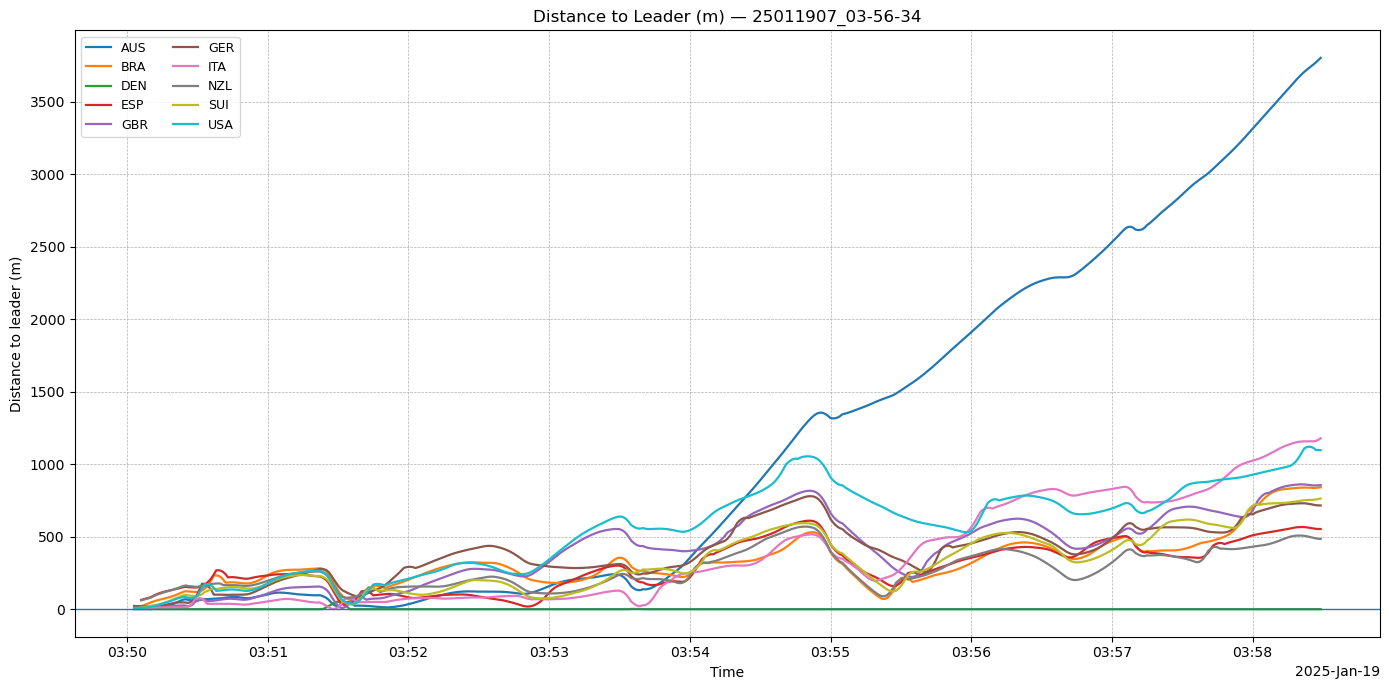

In [23]:
def calculate_distance_to_mark(
    df: pd.DataFrame,
    course_df: pd.DataFrame,
    lat_col: str = 'LATITUDE_GPS_unk',
    lon_col: str = 'LONGITUDE_GPS_unk',
    leg_col: str = 'TRK_LEG_NUM_unk',
) -> pd.DataFrame:
    """
    Calculate straight-line distance to current target mark for each row.

    Parameters
    ----------
    df : pd.DataFrame
        Boat log data
    course_df : pd.DataFrame
        Course marks from parse_course_xml()

    Returns
    -------
    pd.DataFrame
        Original dataframe with added column 'dist_to_mark_m'
    """
    df = df.copy()
    mark_lookup = course_df.set_index('seq_id')[['target_lat', 'target_lon']]

    distances = []

    for _, row in df.iterrows():
        leg = row[leg_col]
        target_seq = int(leg) + 1

        if target_seq not in mark_lookup.index or pd.isna(row[lat_col]):
            distances.append(np.nan)
            continue

        mark = mark_lookup.loc[target_seq]

        # Haversine distance to mark (straight-line)
        dist = haversine_distance(
            row[lat_col], row[lon_col],
            mark['target_lat'], mark['target_lon']
        )

        distances.append(dist)

    df['dist_to_mark_m'] = distances
    return df


def calculate_total_distance_remaining(
    df: pd.DataFrame,
    course_df: pd.DataFrame,
    leg_col: str = 'TRK_LEG_NUM_unk',
) -> pd.DataFrame:
    """
    Calculate total distance remaining on course (current leg + future legs).

    Parameters
    ----------
    df : pd.DataFrame
        Boat log data with 'dist_to_mark_m' column
    course_df : pd.DataFrame
        Course marks from parse_course_xml()

    Returns
    -------
    pd.DataFrame
        Original dataframe with added column 'total_dist_remaining_m'
    """
    df = df.copy()

    # Pre-calculate leg distances (distance between consecutive marks)
    leg_distances = {}
    for i in range(1, len(course_df)):
        prev_mark = course_df.iloc[i-1]
        curr_mark = course_df.iloc[i]
        leg_distances[i] = haversine_distance(
            prev_mark['target_lat'], prev_mark['target_lon'],
            curr_mark['target_lat'], curr_mark['target_lon']
        )

    max_leg = course_df['seq_id'].max() - 1  # Last leg number

    total_remaining = []

    for _, row in df.iterrows():
        leg = int(row[leg_col])
        dist_to_mark = row['dist_to_mark_m']

        if pd.isna(dist_to_mark):
            total_remaining.append(np.nan)
            continue

        # Sum distances of remaining legs after current one
        remaining_leg_dist = sum(
            leg_distances.get(l, 0) for l in range(leg + 1, max_leg + 1)
        )

        total = dist_to_mark + remaining_leg_dist
        total_remaining.append(total)

    df['total_dist_remaining_m'] = total_remaining
    return df


def get_race_start_time(xml_path: str) -> pd.Timestamp:
    """
    Extract the race start time from the course XML.

    Returns the start time converted to UTC.
    """
    with open(xml_path, 'r') as f:
        soup = BeautifulSoup(f, 'xml')

    start_tag = soup.find('RaceStartTime')
    start_str = start_tag['Start']

    # Parse with timezone and convert to UTC
    start_time = pd.to_datetime(start_str).tz_convert('UTC').tz_localize(None)
    return start_time


def get_first_finisher_time(
    all_boats: dict,
    race_start: pd.Timestamp,
    final_leg: int = 7,
    time_col: str = 'DATETIME',
    leg_col: str = 'TRK_LEG_NUM_unk',
) -> tuple:
    """
    Find when the first boat reaches the final leg (finishes the race).

    Only considers finishes AFTER the race start time.

    Parameters
    ----------
    all_boats : dict
        Dictionary of boat_name -> DataFrame
    race_start : pd.Timestamp
        Race start time - only look for finishes after this
    final_leg : int
        The leg number that indicates a boat has finished (default 7 for this race)
    time_col : str
        Column name for datetime
    leg_col : str
        Column name for leg number

    Returns
    -------
    tuple
        (finish_time, winning_boat) - timestamp when first boat finishes and boat name
    """
    first_finish = None
    winner = None

    for boat_name, df in all_boats.items():
        df = df.copy()
        df[time_col] = pd.to_datetime(df[time_col])

        # Filter to only data AFTER race start
        df = df[df[time_col] >= race_start]

        # Find when this boat reached the final leg
        final_leg_data = df[df[leg_col] == final_leg]
        if len(final_leg_data) > 0:
            finish_time = final_leg_data[time_col].min()
            if first_finish is None or finish_time < first_finish:
                first_finish = finish_time
                winner = boat_name

    return first_finish, winner


def calculate_distance_to_leader(
    all_boats: dict,
    course_df: pd.DataFrame,
    race_start_time: pd.Timestamp,
    race_end_time: pd.Timestamp = None,
    time_col: str = 'DATETIME',
    leg_col: str = 'TRK_LEG_NUM_unk',
    min_boats: int = 5,
    min_leg: int = 1,
) -> pd.DataFrame:
    """
    Calculate distance to leader for all boats at each timestamp.

    Only includes data between race start and end times, and only after
    boats have crossed the start line (leg >= min_leg).
    Forward fills missing data for boats without a reading at a given second.
    Only calculates positions when at least min_boats have valid data.

    Parameters
    ----------
    all_boats : dict
        Dictionary of boat_name -> DataFrame
    course_df : pd.DataFrame
        Course marks from parse_course_xml()
    race_start_time : pd.Timestamp
        Race start time from XML (UTC)
    race_end_time : pd.Timestamp, optional
        Race end time (when first boat finishes). Data stops BEFORE this time.
    min_boats : int
        Minimum number of boats with data required to calculate positions
    min_leg : int
        Minimum leg number to include (1 = after crossing start line)

    Returns
    -------
    pd.DataFrame
        Combined dataframe with columns: DATETIME, BOAT, dist_to_leader_m,
        is_leader, position
    """
    processed_boats = {}

    # Process each boat
    for boat_name, df in all_boats.items():
        df = df.copy()
        df[time_col] = pd.to_datetime(df[time_col])

        # Filter to racing data only (between start and end times)
        # Use >= for start but < for end (exclusive) to stop before winner crosses finish
        df = df[df[time_col] >= race_start_time].copy()
        if race_end_time is not None:
            df = df[df[time_col] < race_end_time].copy()

        # Filter to only include data after crossing start line
        df = df[df[leg_col] >= min_leg].copy()

        if len(df) == 0:
            continue

        # Calculate distance to mark and total remaining
        df = calculate_distance_to_mark(df, course_df)
        df = calculate_total_distance_remaining(df, course_df)

        df['BOAT'] = boat_name
        df = df[[time_col, 'BOAT', 'total_dist_remaining_m', leg_col]].copy()
        df = df.set_index(time_col)

        processed_boats[boat_name] = df

    # Get common time range
    all_times = set()
    for df in processed_boats.values():
        all_times.update(df.index)
    all_times = sorted(all_times)

    # Create result dataframe
    results = []

    # Track last known distance for forward filling
    last_known = {boat: np.nan for boat in processed_boats.keys()}

    for t in all_times:
        # Get each boat's distance at this timestamp
        boat_distances = {}

        for boat_name, df in processed_boats.items():
            if t in df.index:
                dist = df.loc[t, 'total_dist_remaining_m']
                if isinstance(dist, pd.Series):
                    dist = dist.iloc[0]
                if not pd.isna(dist):
                    last_known[boat_name] = dist
                boat_distances[boat_name] = last_known[boat_name]
            else:
                # Forward fill with last known value
                boat_distances[boat_name] = last_known[boat_name]

        # Find leader (minimum distance remaining)
        valid_distances = {k: v for k, v in boat_distances.items() if not pd.isna(v)}

        # Skip if not enough boats have data yet
        if len(valid_distances) < min_boats:
            continue

        # Sort boats by distance to get positions
        sorted_boats = sorted(valid_distances.items(), key=lambda x: x[1])
        position_map = {boat: pos + 1 for pos, (boat, _) in enumerate(sorted_boats)}

        leader = sorted_boats[0][0]
        leader_dist = sorted_boats[0][1]

        # Calculate distance to leader for each boat
        for boat_name, dist in boat_distances.items():
            if pd.isna(dist):
                continue

            results.append({
                'DATETIME': t,
                'BOAT': boat_name,
                'total_dist_remaining_m': dist,
                'dist_to_leader_m': dist - leader_dist,
                'is_leader': boat_name == leader,
                'position': position_map.get(boat_name, np.nan),
            })

    return pd.DataFrame(results)


def get_leader_changes(dtl_df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract only the timestamps where leadership changed from one boat to another.

    Parameters
    ----------
    dtl_df : pd.DataFrame
        Output from calculate_distance_to_leader()

    Returns
    -------
    pd.DataFrame
        DataFrame with DATETIME, BOAT, previous_leader columns
    """
    # Get leader at each timestamp
    leaders = dtl_df[dtl_df['is_leader']][['DATETIME', 'BOAT']].copy()
    leaders = leaders.sort_values('DATETIME').reset_index(drop=True)

    # Find where leader changes
    leaders['previous_leader'] = leaders['BOAT'].shift(1)
    leader_changes = leaders[leaders['BOAT'] != leaders['previous_leader']].copy()

    return leader_changes[['DATETIME', 'BOAT', 'previous_leader']]


# === Calculate Distance to Leader ===

# Parse course and get start time from XML
xml_path = 'Data/Race_XMLs/25011907_03-56-34.xml'
course = parse_course_xml(xml_path)
race_start = get_race_start_time(xml_path)
print(f"Race start time (UTC): {race_start}")

# Find when first boat finishes (reaches leg 7)
race_end, winner = get_first_finisher_time(all_boats, race_start, final_leg=7)
print(f"Race end time (UTC): {race_end} - Winner: {winner}")
print(f"Race duration: {race_end - race_start}")

# Calculate distance to leader for all boats (only during the race, after crossing start)
dtl_df = calculate_distance_to_leader(
    all_boats, course, race_start, 
    race_end_time=race_end, 
    min_boats=5,
    min_leg=1,  # Only include data after boats cross start line
)

print(f"\nTotal records: {len(dtl_df)}")

if len(dtl_df) == 0:
    print("\nWARNING: No data returned. Check that:")
    print("  - Race start/end times match the boat log data")
    print("  - Boats have TRK_LEG_NUM_unk >= 1 during the race window")
    print(f"  - Race start: {race_start}")
    print(f"  - Race end: {race_end}")
else:
    print(f"\nSample of distance to leader data:")
    print(dtl_df.head(20))

    # Show actual leader changes (when leadership passes to a different boat)
    leader_changes = get_leader_changes(dtl_df)
    print(f"\nLeader changes during race ({len(leader_changes)} changes):")
    print(leader_changes)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_distance_to_leader_timeseries(
    dtl_df: pd.DataFrame,
    time_col: str = "DATETIME",
    boat_col: str = "BOAT",
    value_col: str = "dist_to_leader_m",
    smooth_seconds: int | None = None,
    resample: str | None = None,   # e.g. "1S", "2S", "5S", "1min"
    boats: list[str] | None = None,
    show_leader_zero_line: bool = True,
    title: str | None = "Distance to Leader over Time",
    figsize: tuple[int, int] = (14, 7),
) -> None:
    """
    Plot each boat's distance-to-leader through time.

    Parameters
    ----------
    dtl_df : pd.DataFrame
        Output from calculate_distance_to_leader()
    smooth_seconds : int, optional
        Rolling mean window (in seconds) applied per boat (after any resample).
    resample : str, optional
        Pandas offset alias to resample to a regular timeline (e.g. "1S", "5S").
        Uses mean within bins. Helpful to reduce noise / standardize time steps.
    boats : list[str], optional
        Subset of boat names to plot.
    """
    if dtl_df is None or len(dtl_df) == 0:
        print("dtl_df is empty — nothing to plot.")
        return

    d = dtl_df.copy()
    d[time_col] = pd.to_datetime(d[time_col])

    if boats is not None:
        d = d[d[boat_col].isin(boats)].copy()

    # Pivot to wide: index=time, columns=boat, values=dist_to_leader
    wide = d.pivot_table(
        index=time_col,
        columns=boat_col,
        values=value_col,
        aggfunc="last"  # if duplicates at same timestamp exist, keep last
    ).sort_index()

    # Optional: resample to regular time grid
    if resample is not None:
        wide = wide.resample(resample).mean()

    # Optional: rolling smoothing (per boat)
    if smooth_seconds is not None and smooth_seconds > 1:
        # If resampled to seconds, this is straightforward. If not, still works as row-based window.
        wide = wide.rolling(window=smooth_seconds, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=figsize)

    # Plot each boat as a separate line
    for boat in wide.columns:
        ax.plot(wide.index, wide[boat], label=str(boat), linewidth=1.6)

    if show_leader_zero_line:
        ax.axhline(0, linewidth=1)

    ax.set_title(title if title else "")
    ax.set_xlabel("Time")
    ax.set_ylabel("Distance to leader (m)")

    # Nicely format time axis
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.legend(loc="best", ncol=2, fontsize=9)

    plt.tight_layout()
    plt.show()

if len(dtl_df) > 0:
    plot_distance_to_leader_timeseries(
        dtl_df,
        resample="1S",          # optional but usually nice for racing data
        smooth_seconds=5,       # optional smoothing
        title=f"Distance to Leader (m) — {xml_path.split('/')[-1].replace('.xml', '')}"
    )

## Question 5: Given a course XML, along with a wind speed and direction and a polar, calculate the minimum number of tacks or gybes for each leg of the course and each gate mark on the leg.

My approach:
1. Create a function that returns the optimal angles for sailing upwind and downwind based direction and speed inputs from the polar data given. Linear interpolation from polar data was used.
2. Assume boats sail on these TWD angles the whole time on either tack. (Assuming tacks to be instantaneous and no VMG gain or loss in manoeuvres.)
3. Based on the boundaries and the marks positions work out the total vertical distance that must be sailed using trigonometry. Likewise we can work out the horizontal distance that must be sailed to achieve the best VMG. Divide this distance by the boundary width to get the number of tacks and gybes required for each leg. Account for the mark position, and assume the boat will pass through a point equidistant between them. 

Other Assumptions:
I have assumed the desired moding is best VMG, but am aware in a race scenario a boat may pinch or sink lower downwind in order to reduce a manoeuvre. For simplification this has been ignored.

In [18]:
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, Legend
from bokeh.palettes import Viridis256, Turbo256
import numpy as np

# Load polar data
polar_df = pd.read_csv('Data/2502 m8_APW_HSB2_HSRW.kph.csv')

# First column is TWA, rest are TWS values
twa_col = polar_df.columns[0]
tws_values = [float(c) for c in polar_df.columns[1:]]

# Extract TWA values
twa_values = polar_df[twa_col].values

print(f"TWA range: {twa_values.min()}° to {twa_values.max()}°")
print(f"TWS values (km/h): {tws_values}")
print(f"\nPolar data shape: {polar_df.shape}")
print(polar_df.head())


def plot_polar_diagram(polar_df: pd.DataFrame, tws_to_plot: list = None):
    """
    Create a polar diagram showing boat speed vs TWA for different wind speeds.
    
    Parameters
    ----------
    polar_df : pd.DataFrame
        Polar data with TWA as first column and TWS as other columns
    tws_to_plot : list, optional
        List of TWS values to plot. If None, plots a selection.
    """
    twa_col = polar_df.columns[0]
    tws_cols = polar_df.columns[1:]
    
    # Get TWA values in radians (polar plot uses radians)
    # Mirror the values to show both port and starboard
    twa_deg = polar_df[twa_col].values
    
    # Select which TWS to plot (pick a subset for clarity)
    if tws_to_plot is None:
        # Select ~6 wind speeds spread across the range
        all_tws = [float(c) for c in tws_cols]
        indices = [0, 2, 4, 7, 10, 14]  # ~3.6, 10.9, 14.5, 21.8, 32.7, 50.8 km/h
        tws_to_plot = [all_tws[i] for i in indices if i < len(all_tws)]
    
    # Create figure with appropriate size
    p = figure(
        title='SailGP F50 Polar Diagram',
        width=800,
        height=800,
        x_axis_label='Boat Speed (km/h)',
        y_axis_label='Boat Speed (km/h)',
        match_aspect=True,
    )
    
    # Use a color palette
    n_colors = len(tws_to_plot)
    colors = [Turbo256[int(i * 255 / (n_colors - 1))] for i in range(n_colors)]
    
    legend_items = []
    
    for i, tws in enumerate(tws_to_plot):
        tws_str = str(tws)
        if tws_str not in tws_cols:
            continue
            
        # Get boat speeds for this TWS
        boat_speeds = polar_df[tws_str].values
        
        # Convert polar coordinates (TWA, boat_speed) to cartesian (x, y)
        # TWA = 0 is upwind, 180 is downwind
        # In polar plot: angle from top (north), clockwise
        # x = speed * sin(TWA), y = speed * cos(TWA)
        
        # Plot starboard tack (positive angles)
        twa_rad = np.deg2rad(twa_deg)
        x_stbd = boat_speeds * np.sin(twa_rad)
        y_stbd = boat_speeds * np.cos(twa_rad)
        
        # Plot port tack (mirror - negative angles)
        x_port = -boat_speeds * np.sin(twa_rad)
        y_port = boat_speeds * np.cos(twa_rad)
        
        # Combine for continuous curve (port reversed + starboard)
        x_full = np.concatenate([x_port[::-1], x_stbd])
        y_full = np.concatenate([y_port[::-1], y_stbd])
        
        color = colors[i]
        line = p.line(x_full, y_full, line_width=2, color=color, alpha=0.8)
        legend_items.append((f"TWS {tws} km/h", [line]))
    
    # Add reference circles for boat speed
    for speed in [20, 40, 60, 80]:
        theta = np.linspace(0, 2 * np.pi, 100)
        x_circle = speed * np.cos(theta)
        y_circle = speed * np.sin(theta)
        p.line(x_circle, y_circle, line_width=0.5, color='gray', alpha=0.3)
        p.text([speed + 1], [1], text=[f'{speed}'], text_font_size='8pt', text_color='gray')
    
    # Add TWA reference lines
    for twa in [30, 60, 90, 120, 150]:
        twa_rad = np.deg2rad(twa)
        max_speed = 90
        # Starboard
        p.line([0, max_speed * np.sin(twa_rad)], [0, max_speed * np.cos(twa_rad)], 
               line_width=0.5, color='gray', alpha=0.3, line_dash='dashed')
        # Port
        p.line([0, -max_speed * np.sin(twa_rad)], [0, max_speed * np.cos(twa_rad)], 
               line_width=0.5, color='gray', alpha=0.3, line_dash='dashed')
        # Label
        p.text([max_speed * np.sin(twa_rad) * 1.05], [max_speed * np.cos(twa_rad) * 1.05], 
               text=[f'{twa}°'], text_font_size='8pt', text_color='gray')

    
    # Add legend
    legend = Legend(items=legend_items, location='bottom_right')
    legend.click_policy = 'hide'
    p.add_layout(legend, 'right')
    
    # Center the plot on 0,0
    p.x_range.start = -100
    p.x_range.end = 100
    p.y_range.start = -100
    p.y_range.end = 100
    
    show(p)


# Create polar diagram
plot_polar_diagram(polar_df)

print("\n=== Polar Data Analysis ===")
print(f"Maximum boat speed: {polar_df.iloc[:, 1:].max().max():.1f} km/h")
print(f"Optimal TWA for max speed varies with wind speed")

TWA range: 10° to 180°
TWS values (km/h): [3.6, 7.3, 10.9, 12.7, 14.5, 18.2, 21.8, 25.4, 29.0, 32.7, 36.3, 39.9, 43.6, 47.2, 50.8]

Polar data shape: (46, 16)
   TWA/TWS   3.6   7.3   10.9   12.7   14.5   18.2   21.8   25.4     29  \
0       10  0.48  1.00   1.50   1.81   3.10   4.20   5.61   6.29   7.13   
1       20  1.04  2.18   3.27   3.92   6.70   9.18  12.05  13.73  15.45   
2       30  1.78  3.74   5.65   6.80  11.58  15.75  20.91  23.67  26.50   
3       40  2.94  6.16   9.33  11.12  18.94  25.91  34.27  38.90  43.65   
4       42  3.25  6.84  10.26  12.27  20.93  28.59  37.94  42.81  48.09   

    32.7   36.3   39.9   43.6   47.2   50.8  
0   7.95   8.35   8.56   8.59   8.61   8.62  
1  17.39  18.23  18.31  18.57  18.60  18.62  
2  29.82  31.23  31.59  31.93  31.97  32.02  
3  49.21  51.40  51.88  52.31  52.38  52.46  
4  54.27  57.25  57.42  57.88  57.95  58.04  



=== Polar Data Analysis ===
Maximum boat speed: 84.9 km/h
Optimal TWA for max speed varies with wind speed


In [19]:
from scipy.interpolate import interp1d

def calculate_vmg(boat_speed: np.ndarray, twa: np.ndarray, upwind: bool = True) -> np.ndarray:
    """
    Calculate Velocity Made Good (VMG) for given boat speeds and TWA.
    
    Upwind VMG = boat_speed * cos(TWA)  (maximizing progress toward wind)
    Downwind VMG = boat_speed * cos(180 - TWA)  (maximizing progress away from wind)
    
    Parameters
    ----------
    boat_speed : np.ndarray
        Boat speeds in km/h
    twa : np.ndarray
        True Wind Angles in degrees
    upwind : bool
        If True, calculate upwind VMG. If False, calculate downwind VMG.
        
    Returns
    -------
    np.ndarray
        VMG values (positive = good progress in desired direction)
    """
    twa_rad = np.deg2rad(twa)
    if upwind:
        return boat_speed * np.cos(twa_rad)
    else:
        return boat_speed * np.cos(np.deg2rad(180) - twa_rad)


def find_optimal_angles_from_polar(polar_df: pd.DataFrame) -> pd.DataFrame:
    """
    Find optimal upwind and downwind TWA for each wind speed in polar table.
    
    Calculates VMG for all TWA values and finds the angle that maximizes
    VMG for both upwind (TWA < 90) and downwind (TWA > 90).
    
    Parameters
    ----------
    polar_df : pd.DataFrame
        Polar data with TWA as first column and TWS as other columns
        
    Returns
    -------
    pd.DataFrame
        Columns: TWS, optimal_upwind_twa, upwind_vmg, upwind_boat_speed,
                 optimal_downwind_twa, downwind_vmg, downwind_boat_speed
    """
    twa_col = polar_df.columns[0]
    tws_cols = polar_df.columns[1:]
    
    twa_values = polar_df[twa_col].values
    
    results = []
    
    for tws_str in tws_cols:
        tws = float(tws_str)
        boat_speeds = polar_df[tws_str].values
        
        # Upwind: TWA < 90 degrees
        upwind_mask = twa_values < 90
        upwind_twa = twa_values[upwind_mask]
        upwind_speeds = boat_speeds[upwind_mask]
        upwind_vmg = calculate_vmg(upwind_speeds, upwind_twa, upwind=True)
        
        best_upwind_idx = np.argmax(upwind_vmg)
        
        # Downwind: TWA > 90 degrees
        downwind_mask = twa_values > 90
        downwind_twa = twa_values[downwind_mask]
        downwind_speeds = boat_speeds[downwind_mask]
        downwind_vmg = calculate_vmg(downwind_speeds, downwind_twa, upwind=False)
        
        best_downwind_idx = np.argmax(downwind_vmg)
        
        results.append({
            'TWS': tws,
            'optimal_upwind_twa': upwind_twa[best_upwind_idx],
            'upwind_vmg': upwind_vmg[best_upwind_idx],
            'upwind_boat_speed': upwind_speeds[best_upwind_idx],
            'optimal_downwind_twa': downwind_twa[best_downwind_idx],
            'downwind_vmg': downwind_vmg[best_downwind_idx],
            'downwind_boat_speed': downwind_speeds[best_downwind_idx],
        })
    
    return pd.DataFrame(results)


def create_optimal_angle_interpolator(polar_df: pd.DataFrame) -> dict:
    """
    Create interpolation functions for optimal sailing angles.
    
    Returns functions that accept any wind speed and return the optimal
    TWA for upwind or downwind sailing (based on VMG optimization).
    
    Parameters
    ----------
    polar_df : pd.DataFrame
        Polar data with TWA as first column and TWS as other columns
        
    Returns
    -------
    dict with keys:
        'upwind_twa': function(tws) -> optimal upwind TWA
        'upwind_vmg': function(tws) -> expected upwind VMG
        'upwind_speed': function(tws) -> expected boat speed at optimal angle
        'downwind_twa': function(tws) -> optimal downwind TWA
        'downwind_vmg': function(tws) -> expected downwind VMG
        'downwind_speed': function(tws) -> expected boat speed at optimal angle
        'tws_range': (min_tws, max_tws) valid interpolation range
    """
    # First find optimal angles at each discrete TWS
    optimal_df = find_optimal_angles_from_polar(polar_df)
    
    tws_values = optimal_df['TWS'].values
    
    # Create interpolation functions (linear, with extrapolation bounds)
    interpolators = {
        'upwind_twa': interp1d(
            tws_values, optimal_df['optimal_upwind_twa'].values,
            kind='linear', fill_value='extrapolate'
        ),
        'upwind_vmg': interp1d(
            tws_values, optimal_df['upwind_vmg'].values,
            kind='linear', fill_value='extrapolate'
        ),
        'upwind_speed': interp1d(
            tws_values, optimal_df['upwind_boat_speed'].values,
            kind='linear', fill_value='extrapolate'
        ),
        'downwind_twa': interp1d(
            tws_values, optimal_df['optimal_downwind_twa'].values,
            kind='linear', fill_value='extrapolate'
        ),
        'downwind_vmg': interp1d(
            tws_values, optimal_df['downwind_vmg'].values,
            kind='linear', fill_value='extrapolate'
        ),
        'downwind_speed': interp1d(
            tws_values, optimal_df['downwind_boat_speed'].values,
            kind='linear', fill_value='extrapolate'
        ),
        'tws_range': (tws_values.min(), tws_values.max()),
    }
    
    return interpolators


def get_optimal_angles(tws: float, interpolators: dict) -> dict:
    """
    Get optimal upwind and downwind TWA for a given wind speed.
    
    Parameters
    ----------
    tws : float
        True Wind Speed in km/h
    interpolators : dict
        Output from create_optimal_angle_interpolator()
        
    Returns
    -------
    dict with keys:
        'upwind_twa': optimal upwind TWA (degrees)
        'upwind_vmg': expected VMG at optimal angle (km/h)
        'upwind_speed': expected boat speed (km/h)
        'downwind_twa': optimal downwind TWA (degrees)
        'downwind_vmg': expected VMG at optimal angle (km/h)
        'downwind_speed': expected boat speed (km/h)
    """
    return {
        'upwind_twa': float(interpolators['upwind_twa'](tws)),
        'upwind_vmg': float(interpolators['upwind_vmg'](tws)),
        'upwind_speed': float(interpolators['upwind_speed'](tws)),
        'downwind_twa': float(interpolators['downwind_twa'](tws)),
        'downwind_vmg': float(interpolators['downwind_vmg'](tws)),
        'downwind_speed': float(interpolators['downwind_speed'](tws)),
    }


# === Create interpolator from polar data ===
interpolators = create_optimal_angle_interpolator(polar_df)

# Show optimal angles at each discrete TWS from the polar table
optimal_angles_df = find_optimal_angles_from_polar(polar_df)
print("=== Optimal Angles from Polar Table ===")
print(optimal_angles_df.to_string(index=False))

# === Demo: Get optimal angles for any wind speed ===
print("\n=== Interpolated Optimal Angles ===")
print(f"{'TWS (km/h)':<12} {'Upwind TWA':<12} {'Upwind VMG':<12} {'Downwind TWA':<14} {'Downwind VMG':<12}")
print("-" * 62)

for tws in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
    result = get_optimal_angles(tws, interpolators)
    print(f"{tws:<12} {result['upwind_twa']:<12.1f} {result['upwind_vmg']:<12.1f} {result['downwind_twa']:<14.1f} {result['downwind_vmg']:<12.1f}")

# Example: single wind speed lookup
print("\n=== Example: Wind speed = 22 km/h ===")
example = get_optimal_angles(22, interpolators)
print(f"Optimal upwind TWA: {example['upwind_twa']:.1f}° (VMG: {example['upwind_vmg']:.1f} km/h, Boat speed: {example['upwind_speed']:.1f} km/h)")
print(f"Optimal downwind TWA: {example['downwind_twa']:.1f}° (VMG: {example['downwind_vmg']:.1f} km/h, Boat speed: {example['downwind_speed']:.1f} km/h)")

=== Optimal Angles from Polar Table ===
 TWS  optimal_upwind_twa  upwind_vmg  upwind_boat_speed  optimal_downwind_twa  downwind_vmg  downwind_boat_speed
 3.6                  52    3.207596               5.21                   138      4.436575                 5.97
 7.3                  50    6.627140              10.31                   134      7.738494                11.14
10.9                  50    9.616103              14.96                   132      9.755924                14.58
12.7                  54   13.954022              23.74                   128     24.010798                39.00
14.5                  54   23.899348              40.66                   132     31.308621                46.79
18.2                  52   30.228978              49.10                   136     40.649892                56.51
21.8                  48   34.861705              52.10                   140     46.238443                60.36
25.4                  48   37.237118              55.65 

In [20]:
def parse_course_boundaries(xml_path: str) -> list:
    """
    Parse course boundary polygon from XML.
    
    Returns list of (lat, lon) tuples defining the boundary polygon.
    """
    with open(xml_path, 'r') as f:
        soup = BeautifulSoup(f, 'xml')
    
    boundary = soup.find('CourseLimit', {'name': 'Boundary'})
    if boundary is None:
        return []
    
    points = []
    for limit in boundary.find_all('Limit'):
        lat = float(limit['Lat'])
        lon = float(limit['Lon'])
        points.append((lat, lon))
    
    return points


def parse_course_marks_with_gates(xml_path: str) -> pd.DataFrame:
    """
    Parse course marks including individual gate mark positions.
    """
    with open(xml_path, 'r') as f:
        soup = BeautifulSoup(f, 'xml')
    
    compound_marks = {}
    for cm in soup.find_all('CompoundMark'):
        cm_id = int(cm['CompoundMarkID'])
        marks = cm.find_all('Mark')
        
        mark_positions = []
        for m in marks:
            mark_positions.append({
                'lat': float(m['TargetLat']),
                'lon': float(m['TargetLng']),
                'name': m['Name'],
            })
        
        lats = [m['lat'] for m in mark_positions]
        lons = [m['lon'] for m in mark_positions]
        
        compound_marks[cm_id] = {
            'name': cm['Name'],
            'center_lat': np.mean(lats),
            'center_lon': np.mean(lons),
            'is_gate': len(marks) > 1,
            'gate_marks': mark_positions if len(marks) > 1 else None,
            'gate_width': haversine_distance(lats[0], lons[0], lats[-1], lons[-1]) if len(marks) > 1 else 0,
        }
    
    sequence = []
    for corner in soup.find('CompoundMarkSequence').find_all('Corner'):
        seq_id = int(corner['SeqID'])
        cm_id = int(corner['CompoundMarkID'])
        cm = compound_marks[cm_id]
        sequence.append({
            'seq_id': seq_id,
            'compound_mark_id': cm_id,
            'name': cm['name'],
            'center_lat': cm['center_lat'],
            'center_lon': cm['center_lon'],
            'is_gate': cm['is_gate'],
            'gate_width': cm['gate_width'],
        })
    
    return pd.DataFrame(sequence)


def get_race_wind_from_course_marks(
    course_marks_path: str,
    race_start: str = '2025-01-19 03:08:00',
    race_end: str = '2025-01-19 03:16:00',
) -> tuple:
    """
    Get average wind conditions from course marks during race time.
    """
    course_marks = pd.read_csv(course_marks_path)
    course_marks['DATETIME'] = pd.to_datetime(course_marks['DATETIME'])
    
    mask = (course_marks['DATETIME'] >= race_start) & (course_marks['DATETIME'] <= race_end)
    race_wind = course_marks[mask]
    
    # Circular mean for TWD
    twd_rad = np.deg2rad(race_wind['TWD_deg'].values)
    avg_sin = np.mean(np.sin(twd_rad))
    avg_cos = np.mean(np.cos(twd_rad))
    avg_twd = (np.rad2deg(np.arctan2(avg_sin, avg_cos)) + 360) % 360
    
    avg_tws = race_wind['TWS_km_h_1'].mean()
    
    return avg_twd, avg_tws


def calculate_twa_to_awa(twa_deg: float, tws: float, boat_speed: float) -> float:
    """
    Convert True Wind Angle to Apparent Wind Angle.
    
    AWA = atan2(TWS * sin(TWA), TWS * cos(TWA) + Boat_Speed)
    """
    twa_rad = np.deg2rad(twa_deg)
    awa_rad = np.arctan2(tws * np.sin(twa_rad), tws * np.cos(twa_rad) + boat_speed)
    return abs(np.rad2deg(awa_rad))


def calculate_boat_heading(twd: float, twa: float, tack: str = 'starboard') -> float:
    """
    Calculate boat heading given wind direction and TWA.
    
    Parameters
    ----------
    twd : float
        True Wind Direction (where wind comes FROM)
    twa : float
        True Wind Angle (always positive)
    tack : str
        'starboard' or 'port'
    """
    if tack == 'starboard':
        heading = (twd + twa) % 360
    else:
        heading = (twd - twa) % 360
    return heading


def calculate_boundary_width_for_leg(
    start_mark: dict,
    end_mark: dict,
    boundary_points: list,
    twd: float,
) -> float:
    """
    Calculate the usable course width perpendicular to the wind for a leg.
    """
    if len(boundary_points) < 3:
        return 500  # Default if no boundary
    
    mid_lat = (start_mark['center_lat'] + end_mark['center_lat']) / 2
    mid_lon = (start_mark['center_lon'] + end_mark['center_lon']) / 2
    
    m_per_deg_lat = 111320
    m_per_deg_lon = 111320 * np.cos(np.deg2rad(mid_lat))
    
    def to_xy(lat, lon):
        return ((lon - mid_lon) * m_per_deg_lon, (lat - mid_lat) * m_per_deg_lat)
    
    boundary_xy = [to_xy(lat, lon) for lat, lon in boundary_points]
    
    perp_angle = np.deg2rad(twd + 90)
    perp_vec = (np.sin(perp_angle), np.cos(perp_angle))
    
    projections = [x * perp_vec[0] + y * perp_vec[1] for x, y in boundary_xy]
    
    return max(projections) - min(projections)


def calculate_min_manoeuvres(
    leg_distance: float,
    angle_to_wind: float,
    optimal_twa: float,
    boundary_width: float,
    is_upwind: bool,
) -> int:
    """
    Calculate minimum tacks or gybes needed for a leg.
    
    Uses simplified geometry:
    - Wind-relative coordinates: Y = upwind, X = cross-wind
    - Mark at angle_to_wind from upwind direction
    - Boat sails at optimal_twa to maximize VMG
    - Boundaries limit lateral movement to ± boundary_width/2
    
    Assumes instantaneous, lossless manoeuvres.
    
    Parameters
    ----------
    leg_distance : float
        Distance to the mark in meters
    angle_to_wind : float
        Angle from wind to mark (0° = into wind, 180° = downwind)
    optimal_twa : float
        Optimal True Wind Angle for best VMG
    boundary_width : float
        Width of course boundaries perpendicular to wind
    is_upwind : bool
        True if angle_to_wind < 90°
    
    Returns
    -------
    int
        Minimum number of tacks or gybes required
    """
    # Check if we can sail straight to the mark (no manoeuvres needed)
    if is_upwind:
        # Upwind: can lay mark if angle_to_wind >= optimal_twa
        # (mark is "outside" our layline, we can point high enough)
        if angle_to_wind >= optimal_twa:
            return 0
    else:
        # Downwind: can lay mark if angle_to_wind <= optimal_twa
        # (mark is not so deep that we need to gybe)
        if angle_to_wind <= optimal_twa:
            return 0
    
    # We need to tack/gybe. Calculate the geometry.
    if is_upwind:
        # VMG distance to cover (component directly upwind)
        vmg_distance = leg_distance * np.cos(np.deg2rad(angle_to_wind))
        sailing_angle = optimal_twa
    else:
        # For downwind, work in "downwind-relative" coordinates
        # angle from dead downwind = 180 - angle_to_wind
        # optimal angle from dead downwind = 180 - optimal_twa
        effective_angle = 180 - angle_to_wind
        effective_optimal = 180 - optimal_twa
        vmg_distance = leg_distance * np.cos(np.deg2rad(effective_angle))
        sailing_angle = effective_optimal
    
    # When sailing at optimal angle:
    # - For each meter of VMG, we move tan(sailing_angle) meters laterally
    # - Each boundary-to-boundary crossing covers:
    #     VMG = boundary_width / tan(sailing_angle)
    
    tan_angle = np.tan(np.deg2rad(sailing_angle))
    
    if tan_angle < 0.001:  # Nearly straight, avoid division issues
        return 1
    
    vmg_per_crossing = boundary_width / tan_angle
    
    # Number of full crossings needed to cover the VMG distance
    crossings_needed = vmg_distance / vmg_per_crossing
    
    # Manoeuvres = crossings - 1 (we tack/gybe between crossings)
    # But we need at least 1 manoeuvre since we can't sail straight
    min_manoeuvres = max(1, int(np.ceil(crossings_needed)) - 1)
    
    return min_manoeuvres


def calculate_min_manoeuvres_for_leg(
    start_mark: dict,
    end_mark: dict,
    twd: float,
    tws: float,
    interpolators: dict,
    boundary_width: float,
) -> dict:
    """
    Calculate minimum tacks or gybes needed for a leg.
    
    Returns detailed information including optimal angles, headings, and manoeuvre count.
    """
    # Leg geometry
    leg_bearing = compute_bearing(
        start_mark['center_lat'], start_mark['center_lon'],
        end_mark['center_lat'], end_mark['center_lon']
    )
    leg_distance = haversine_distance(
        start_mark['center_lat'], start_mark['center_lon'],
        end_mark['center_lat'], end_mark['center_lon']
    )
    
    # Angle to wind (0° = directly into wind, 180° = dead downwind)
    angle_diff = (leg_bearing - twd + 180) % 360 - 180
    angle_to_wind = abs(angle_diff)
    
    # Get optimal angles from polar data
    optimal = get_optimal_angles(tws, interpolators)
    optimal_upwind_twa = optimal['upwind_twa']
    optimal_downwind_twa = optimal['downwind_twa']
    
    is_upwind = angle_to_wind < 90
    
    if is_upwind:
        optimal_twa = optimal_upwind_twa
        optimal_boat_speed = optimal['upwind_speed']
        manoeuvre_type = 'tack'
    else:
        optimal_twa = optimal_downwind_twa
        optimal_boat_speed = optimal['downwind_speed']
        manoeuvre_type = 'gybe'
    
    # Calculate AWA (what sailor sees on instruments)
    optimal_awa = calculate_twa_to_awa(optimal_twa, tws, optimal_boat_speed)
    
    # Calculate boat headings for each tack
    heading_starboard = calculate_boat_heading(twd, optimal_twa, 'starboard')
    heading_port = calculate_boat_heading(twd, optimal_twa, 'port')
    
    # Calculate minimum manoeuvres
    min_manoeuvres = calculate_min_manoeuvres(
        leg_distance, angle_to_wind, optimal_twa, boundary_width, is_upwind
    )
    
    # Determine if we can sail straight
    if is_upwind:
        can_sail_straight = angle_to_wind >= optimal_twa
    else:
        can_sail_straight = angle_to_wind <= optimal_twa
    
    if can_sail_straight:
        manoeuvre_type = 'none'
    
    return {
        'leg_bearing': leg_bearing,
        'leg_distance': leg_distance,
        'angle_to_wind': angle_to_wind,
        'is_upwind': is_upwind,
        'can_sail_straight': can_sail_straight,
        'optimal_twa': optimal_twa,
        'optimal_awa': optimal_awa,
        'optimal_boat_speed': optimal_boat_speed,
        'heading_starboard': heading_starboard,
        'heading_port': heading_port,
        'boundary_width': boundary_width,
        'min_manoeuvres': min_manoeuvres,
        'manoeuvre_type': manoeuvre_type,
    }


def calculate_all_leg_manoeuvres(
    xml_path: str,
    twd: float,
    tws: float,
    polar_df: pd.DataFrame,
    skip_first_last: bool = True,
) -> pd.DataFrame:
    """
    Calculate minimum manoeuvres for all legs of a course.
    """
    marks_df = parse_course_marks_with_gates(xml_path)
    boundary = parse_course_boundaries(xml_path)
    interpolators = create_optimal_angle_interpolator(polar_df)
    
    results = []
    num_legs = len(marks_df) - 1
    
    for i in range(num_legs):
        leg_num = i + 1
        
        if skip_first_last and (leg_num == 1 or leg_num == num_legs):
            continue
            
        start_mark = marks_df.iloc[i].to_dict()
        end_mark = marks_df.iloc[i + 1].to_dict()
        
        boundary_width = calculate_boundary_width_for_leg(
            start_mark, end_mark, boundary, twd
        )
        
        leg_result = calculate_min_manoeuvres_for_leg(
            start_mark, end_mark, twd, tws, interpolators, boundary_width
        )
        
        leg_result['leg_num'] = leg_num
        leg_result['from_mark'] = start_mark['name']
        leg_result['to_mark'] = end_mark['name']
        leg_result['to_mark_is_gate'] = end_mark['is_gate']
        leg_result['gate_width'] = end_mark['gate_width']
        
        results.append(leg_result)
    
    return pd.DataFrame(results)


# === Calculate minimum manoeuvres for the race course ===

# Get wind conditions from course marks during race time
course_marks_path = 'Data/Course_Marks_2025-01-19.csv'
avg_twd, avg_tws = get_race_wind_from_course_marks(
    course_marks_path,
    race_start='2025-01-19 03:08:00',
    race_end='2025-01-19 03:16:00',
)

print(f"=== Wind Conditions (from Course Marks during race) ===")
print(f"Average TWD: {avg_twd:.1f}°")
print(f"Average TWS: {avg_tws:.1f} km/h")

# Get optimal angles for this wind speed
opt = get_optimal_angles(avg_tws, interpolators)
print(f"\n=== Optimal Sailing Angles at {avg_tws:.1f} km/h TWS ===")
print(f"UPWIND:")
print(f"  TWA: {opt['upwind_twa']:.1f}°")
print(f"  AWA: {calculate_twa_to_awa(opt['upwind_twa'], avg_tws, opt['upwind_speed']):.1f}°")
print(f"  Boat Speed: {opt['upwind_speed']:.1f} km/h")
print(f"  VMG: {opt['upwind_vmg']:.1f} km/h")
print(f"DOWNWIND:")
print(f"  TWA: {opt['downwind_twa']:.1f}°")
print(f"  AWA: {calculate_twa_to_awa(opt['downwind_twa'], avg_tws, opt['downwind_speed']):.1f}°")
print(f"  Boat Speed: {opt['downwind_speed']:.1f} km/h")
print(f"  VMG: {opt['downwind_vmg']:.1f} km/h")

# Calculate manoeuvres for each leg
xml_path = 'Data/Race_XMLs/25011905_03-13-55.xml'
manoeuvres_df = calculate_all_leg_manoeuvres(
    xml_path, avg_twd, avg_tws, polar_df, 
    skip_first_last=True
)

print(f"\n{'='*70}")
print(f"=== MINIMUM MANOEUVRES PER LEG ===")
print(f"{'='*70}")
print(f"\nAssumptions:")
print(f"  - Boat sails at optimal VMG angles from polar data")
print(f"  - Tacks/gybes are instantaneous with no speed loss")
print(f"  - Course boundaries limit lateral movement")

for _, row in manoeuvres_df.iterrows():
    leg_type = "UPWIND" if row['is_upwind'] else "DOWNWIND"
    gate_str = " (GATE)" if row['to_mark_is_gate'] else ""
    
    print(f"\n--- Leg {row['leg_num']}: {row['from_mark']} → {row['to_mark']}{gate_str} ---")
    print(f"Distance: {row['leg_distance']:.0f}m | Bearing: {row['leg_bearing']:.1f}°")
    print(f"Type: {leg_type} | Angle to wind: {row['angle_to_wind']:.1f}°")
    print(f"Optimal TWA: {row['optimal_twa']:.1f}° | AWA: {row['optimal_awa']:.1f}°")
    print(f"Boat headings: Starboard {row['heading_starboard']:.1f}° | Port {row['heading_port']:.1f}°")
    print(f"Boundary width: {row['boundary_width']:.0f}m")
    
    if row['can_sail_straight']:
        print(f">>> Can sail STRAIGHT to mark (0 manoeuvres)")
    else:
        print(f">>> Minimum {row['manoeuvre_type'].upper()}S: {row['min_manoeuvres']}")

# Summary table
print(f"\n{'='*70}")
print(f"=== SUMMARY TABLE ===")
print(f"{'='*70}")
summary_data = []
for _, row in manoeuvres_df.iterrows():
    summary_data.append({
        'Leg': row['leg_num'],
        'From': row['from_mark'],
        'To': row['to_mark'],
        'Type': 'Up' if row['is_upwind'] else 'Down',
        'Dist(m)': f"{row['leg_distance']:.0f}",
        'Angle': f"{row['angle_to_wind']:.0f}°",
        'Opt TWA': f"{row['optimal_twa']:.0f}°",
        'Opt AWA': f"{row['optimal_awa']:.0f}°",
        'Manoeuvre': row['manoeuvre_type'],
        'Min #': row['min_manoeuvres'],
    })
summary = pd.DataFrame(summary_data)
print(summary.to_string(index=False))

# Totals
total_tacks = manoeuvres_df[manoeuvres_df['manoeuvre_type'] == 'tack']['min_manoeuvres'].sum()
total_gybes = manoeuvres_df[manoeuvres_df['manoeuvre_type'] == 'gybe']['min_manoeuvres'].sum()
print(f"\n=== RACE TOTALS ===")
print(f"Minimum tacks: {int(total_tacks)}")
print(f"Minimum gybes: {int(total_gybes)}")
print(f"Total minimum manoeuvres: {int(total_tacks + total_gybes)}")

=== Wind Conditions (from Course Marks during race) ===
Average TWD: 65.6°
Average TWS: 30.9 km/h

=== Optimal Sailing Angles at 30.9 km/h TWS ===
UPWIND:
  TWA: 45.0°
  AWA: 15.3°
  Boat Speed: 58.1 km/h
  VMG: 41.1 km/h
DOWNWIND:
  TWA: 149.0°
  AWA: 18.8°
  Boat Speed: 73.2 km/h
  VMG: 62.8 km/h

=== MINIMUM MANOEUVRES PER LEG ===

Assumptions:
  - Boat sails at optimal VMG angles from polar data
  - Tacks/gybes are instantaneous with no speed loss
  - Course boundaries limit lateral movement

--- Leg 2: M1 → LG1 (GATE) ---
Distance: 1037m | Bearing: 243.7°
Type: DOWNWIND | Angle to wind: 178.1°
Optimal TWA: 149.0° | AWA: 18.8°
Boat headings: Starboard 214.6° | Port 276.6°
Boundary width: 1146m
>>> Minimum GYBES: 1

--- Leg 3: LG1 → WG1 (GATE) ---
Distance: 1224m | Bearing: 68.4°
Type: UPWIND | Angle to wind: 2.8°
Optimal TWA: 45.0° | AWA: 15.3°
Boat headings: Starboard 110.6° | Port 20.6°
Boundary width: 1146m
>>> Minimum TACKS: 1

--- Leg 4: WG1 → LG1 (GATE) ---
Distance: 1224m | 

## Question 6: Calculate a “tacked” set of variables depending on the tack of the boat, so that sailors don’t need to think about what tack they’re on when looking at measurements. And show the results in a visualisation.


## Question 7: Given a set of tacks (in CSV), and train a model to explain the key features of these tacks when optimizing for vmg. Show appropriate visualisations to explain your conclusions.

I have decided to use a modelling function from sklearn package. I have used the permutation importances method in order to find out which variables are the most important for predicting vmg loss. This is a method I am very faimilar with from my previous work as a sports data analyst. Permutation importance works by taking a variable and randomising the values in that column. It then creates a model (I chose a random forest regressor) in order to try and predict the target variable (vmg loss). The poorer the results when the nominated column have been randomised compared to when they aren't is a good indicator of how useful that variable is in predicting the outcome variable.

This can then indicate to us which of the variables the sailors should focus on when trying to execute accurate tacks and gybes.

I decided to do this for both tacks and gybes just to give myself more context and I was interested in the comparison between tacks and gybes.

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Whisker
from bokeh.transform import factor_cmap
from bokeh.palettes import Category20

# Load manoeuvre summary data
man_df = pd.read_csv('Data/2025-01-19_man_summary.csv')

print(f"=== Manoeuvre Summary Dataset ===")
print(f"Total manoeuvres: {len(man_df)}")
print(f"Tacks: {len(man_df[man_df['type'] == 'tack'])}")
print(f"Gybes: {len(man_df[man_df['type'] == 'gybe'])}")

# Define feature groups
entry_conditions = ['entry_bsp', 'entry_twa', 'entry_rh', 'entry_heel', 'entry_pitch', 'tws']
technique_metrics = ['turning_time', 'max_yaw_rate', 'max_rudder_angle', 'db_down', 'two_DB_time']
daggerboard_mgmt = ['entry_cant', 'exit_cant']
exit_conditions = ['exit_bsp', 'exit_twa', 'exit_rh', 'exit_heel', 'exit_pitch']
ride_height = ['turn_min_rh', 'entry_rh_stability']

# Combine all features
all_features = entry_conditions + technique_metrics + daggerboard_mgmt + exit_conditions + ride_height

# Target variable
target = 'loss_vs_vmg' #'loss_vs_targ_vmg'

# Prepare data - drop rows with missing values in our features or target
model_df = man_df[all_features + [target, 'type', 'BOAT']].copy()
model_df = model_df.dropna()

print(f"\nRows after dropping NaN: {len(model_df)}")
print(f"Features: {len(all_features)}")

# Create feature matrix and target vector
X = model_df[all_features]
y = model_df[target]

# Split data: 70% train, 30% test (stratified by manoeuvre type)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=model_df['type']  # Ensure balanced tacks/gybes in both sets
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Train a Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluate model
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print(f"\n=== Model Performance ===")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

# Calculate permutation importance on TEST set (to avoid overfitting bias)
print(f"\nCalculating permutation importances on test set...")
perm_importance = permutation_importance(
    rf_model, X_test, y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': all_features,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std,
}).sort_values('importance_mean', ascending=True)

# Add feature group labels
def get_feature_group(feat):
    if feat in entry_conditions:
        return 'Entry Conditions'
    elif feat in technique_metrics:
        return 'Technique'
    elif feat in daggerboard_mgmt:
        return 'Daggerboard'
    elif feat in exit_conditions:
        return 'Exit Conditions'
    elif feat in ride_height:
        return 'Ride Height'
    return 'Other'

importance_df['group'] = importance_df['feature'].apply(get_feature_group)

print(f"\n=== Permutation Importances (Test Set) ===")
print(importance_df.sort_values('importance_mean', ascending=False).to_string(index=False))

# Visualize with Bokeh
source = ColumnDataSource(importance_df)

# Create color mapping for groups
groups = importance_df['group'].unique().tolist()
colors = Category20[max(3, len(groups))][:len(groups)]
color_map = factor_cmap('group', palette=colors, factors=groups)

p = figure(
    y_range=importance_df['feature'].tolist(),
    title=f'Permutation Feature Importance for VMG Loss Prediction (Test Set, R²={test_score:.2f})',
    width=900,
    height=600,
    x_axis_label='Mean Importance (decrease in R² when feature is shuffled)',
    toolbar_location='right',
)

# Add horizontal bars
p.hbar(
    y='feature',
    right='importance_mean',
    height=0.7,
    source=source,
    color=color_map,
    legend_field='group',
)

# Add error bars (whiskers)
whisker_source = ColumnDataSource(dict(
    base=importance_df['feature'].tolist(),
    lower=(importance_df['importance_mean'] - importance_df['importance_std']).tolist(),
    upper=(importance_df['importance_mean'] + importance_df['importance_std']).tolist(),
))

p.add_layout(Whisker(
    source=whisker_source,
    base='base',
    lower='lower',
    upper='upper',
    dimension='width',
    line_color='black',
    line_width=1.5,
))

# Add vertical line at 0
p.line([0, 0], [-1, len(all_features)], line_color='gray', line_dash='dashed', line_width=1)

# Configure legend
p.legend.location = 'bottom_right'
p.legend.title = 'Feature Group'
p.legend.click_policy = 'hide'

# Add hover tool
hover = HoverTool(tooltips=[
    ('Feature', '@feature'),
    ('Group', '@group'),
    ('Importance', '@importance_mean{0.000}'),
    ('Std Dev', '@importance_std{0.000}'),
])
p.add_tools(hover)

p.xgrid.grid_line_color = None
p.y_range.range_padding = 0.1

show(p)

# Now split by manoeuvre type
print(f"\n{'='*70}")
print(f"=== SEPARATE ANALYSIS: TACKS vs GYBES ===")
print(f"{'='*70}")


def analyze_manoeuvre_type(man_type: str, df: pd.DataFrame, features: list, target: str):
    """Analyze permutation importance for a specific manoeuvre type."""
    subset = df[df['type'] == man_type].copy()
    subset = subset[features + [target]].dropna()
    
    if len(subset) < 30:
        print(f"Not enough {man_type} samples ({len(subset)})")
        return None
    
    X = subset[features]
    y = subset[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    rf = RandomForestRegressor(
        n_estimators=100, max_depth=8, min_samples_split=5, 
        random_state=42, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    test_r2 = rf.score(X_test, y_test)
    
    perm_imp = permutation_importance(
        rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1
    )
    
    imp_df = pd.DataFrame({
        'feature': features,
        'importance_mean': perm_imp.importances_mean,
        'importance_std': perm_imp.importances_std,
    }).sort_values('importance_mean', ascending=False)
    
    return imp_df, test_r2, len(X_train), len(X_test)


# Analyze tacks
tack_result = analyze_manoeuvre_type('tack', model_df, all_features, target)
if tack_result:
    tack_imp, tack_r2, tack_train_n, tack_test_n = tack_result
    print(f"\n=== TACKS (Train: {tack_train_n}, Test: {tack_test_n}, R²: {tack_r2:.2f}) ===")
    print("Top 10 important features:")
    print(tack_imp.head(10).to_string(index=False))

# Analyze gybes
gybe_result = analyze_manoeuvre_type('gybe', model_df, all_features, target)
if gybe_result:
    gybe_imp, gybe_r2, gybe_train_n, gybe_test_n = gybe_result
    print(f"\n=== GYBES (Train: {gybe_train_n}, Test: {gybe_test_n}, R²: {gybe_r2:.2f}) ===")
    print("Top 10 important features:")
    print(gybe_imp.head(10).to_string(index=False))


# Create side-by-side comparison plot
if tack_result and gybe_result:
    # Merge importance data
    tack_imp['manoeuvre'] = 'Tack'
    gybe_imp['manoeuvre'] = 'Gybe'
    
    # Get top features from each
    top_tack = set(tack_imp.head(8)['feature'])
    top_gybe = set(gybe_imp.head(8)['feature'])
    top_features = list(top_tack | top_gybe)
    
    # Filter to top features and combine
    tack_top = tack_imp[tack_imp['feature'].isin(top_features)].copy()
    gybe_top = gybe_imp[gybe_imp['feature'].isin(top_features)].copy()
    
    # Create grouped bar chart
    from bokeh.models import FactorRange
    from bokeh.transform import dodge
    
    # Prepare data for grouped bars
    features_ordered = (
        pd.concat([tack_top, gybe_top])
        .groupby('feature')['importance_mean']
        .mean()
        .sort_values(ascending=False)
        .index.tolist()
    )
    
    tack_vals = []
    gybe_vals = []
    tack_stds = []
    gybe_stds = []
    
    for f in features_ordered:
        tack_row = tack_imp[tack_imp['feature'] == f]
        gybe_row = gybe_imp[gybe_imp['feature'] == f]
        tack_vals.append(tack_row['importance_mean'].values[0] if len(tack_row) > 0 else 0)
        gybe_vals.append(gybe_row['importance_mean'].values[0] if len(gybe_row) > 0 else 0)
        tack_stds.append(tack_row['importance_std'].values[0] if len(tack_row) > 0 else 0)
        gybe_stds.append(gybe_row['importance_std'].values[0] if len(gybe_row) > 0 else 0)
    
    compare_source = ColumnDataSource(dict(
        features=features_ordered,
        tack=tack_vals,
        gybe=gybe_vals,
        tack_std=tack_stds,
        gybe_std=gybe_stds,
    ))
    
    p2 = figure(
        x_range=features_ordered,
        title=f'Feature Importance: Tacks (R²={tack_r2:.2f}) vs Gybes (R²={gybe_r2:.2f})',
        width=1000,
        height=500,
        y_axis_label='Permutation Importance',
        toolbar_location='right',
    )
    
    p2.vbar(
        x=dodge('features', -0.15, range=p2.x_range),
        top='tack',
        width=0.25,
        source=compare_source,
        color='#1f77b4',
        legend_label='Tacks',
    )
    
    p2.vbar(
        x=dodge('features', 0.15, range=p2.x_range),
        top='gybe',
        width=0.25,
        source=compare_source,
        color='#ff7f0e',
        legend_label='Gybes',
    )
    
    p2.xaxis.major_label_orientation = 0.7
    p2.legend.location = 'top_right'
    p2.legend.click_policy = 'hide'
    p2.y_range.start = 0
    
    # Add hover
    hover2 = HoverTool(tooltips=[
        ('Feature', '@features'),
        ('Tack Importance', '@tack{0.000}'),
        ('Gybe Importance', '@gybe{0.000}'),
    ])
    p2.add_tools(hover2)
    
    show(p2)

=== Manoeuvre Summary Dataset ===
Total manoeuvres: 365
Tacks: 196
Gybes: 169

Rows after dropping NaN: 329
Features: 20

Train set: 230 samples
Test set: 99 samples

=== Model Performance ===
Train R²: 0.922
Test R²: 0.711

Calculating permutation importances on test set...

=== Permutation Importances (Test Set) ===
           feature  importance_mean  importance_std            group
         entry_twa         1.620529        0.194055 Entry Conditions
          exit_twa         0.660530        0.103424  Exit Conditions
         entry_bsp         0.057795        0.019675 Entry Conditions
          exit_bsp         0.033178        0.007234  Exit Conditions
      turning_time         0.029096        0.010619        Technique
       entry_pitch         0.016065        0.007320 Entry Conditions
           db_down         0.006890        0.003809        Technique
      max_yaw_rate         0.003724        0.009096        Technique
               tws         0.003195        0.002621 Entry C


=== SEPARATE ANALYSIS: TACKS vs GYBES ===

=== TACKS (Train: 125, Test: 54, R²: 0.82) ===
Top 10 important features:
     feature  importance_mean  importance_std
   entry_twa         1.632755        0.240723
 entry_pitch         0.060471        0.023939
   exit_cant         0.022458        0.006768
     exit_rh         0.022451        0.006182
max_yaw_rate         0.017539        0.006937
    exit_bsp         0.013885        0.003626
 turn_min_rh         0.013117        0.004815
    entry_rh         0.010891        0.005306
turning_time         0.010487        0.009269
  exit_pitch         0.009531        0.001954

=== GYBES (Train: 105, Test: 45, R²: 0.52) ===
Top 10 important features:
     feature  importance_mean  importance_std
    exit_twa         0.309412        0.098809
   entry_twa         0.300671        0.077757
    exit_bsp         0.083277        0.029451
   entry_bsp         0.022544        0.017631
   exit_cant         0.007711        0.005564
         tws         0.00

## Key Insights

The most important variable for effective, consistent tacks is the entry true wind angle. This shows a far greater permutation importance value than any of the other variables, indicating it is a strong predictor of VMG loss. 
For gybes, there seems to be three main variables of importance - entry TWA, exit TWA and exit BSP. 

In [22]:
# Distribution of VMG Loss for Tacks and Gybes
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.palettes import Category10, Spectral11
from bokeh.models import Legend
from scipy import stats

# Load data
man_df = pd.read_csv('Data/2025-01-19_man_summary.csv')

# Filter out rows with missing loss_vs_vmg
man_df = man_df[man_df['loss_vs_vmg'].notna()].copy()

# Get unique boats (excluding CAN which didn't race)
boats = [b for b in man_df['BOAT'].unique() if b != 'CAN']
boats = sorted(boats)

# Colors for boats
boat_colors = {boat: Spectral11[i % 11] for i, boat in enumerate(boats)}


def plot_vmg_loss_distribution(man_type: str, df: pd.DataFrame, boats: list, boat_colors: dict):
    """
    Plot VMG loss distribution for a specific manoeuvre type.
    Shows individual boat distributions and overall distribution.
    """
    subset = df[df['type'] == man_type].copy()
    
    p = figure(
        title=f'VMG Loss Distribution - {man_type.upper()}S (n={len(subset)})',
        width=900,
        height=450,
        x_axis_label='Loss vs VMG (m) - Lower is better',
        y_axis_label='Density',
        toolbar_location='right',
    )
    
    legend_items = []
    
    # Plot each boat's distribution
    for boat in boats:
        boat_data = subset[subset['BOAT'] == boat]['loss_vs_vmg'].dropna()
        
        if len(boat_data) < 3:
            continue
        
        # Fit KDE
        try:
            kde = stats.gaussian_kde(boat_data)
            x_range = np.linspace(boat_data.min() - 50, boat_data.max() + 50, 200)
            y_vals = kde(x_range)
            
            line = p.line(
                x_range, y_vals, 
                line_width=1.5, 
                color=boat_colors[boat], 
                alpha=0.6,
            )
            legend_items.append((f"{boat} (n={len(boat_data)}, μ={boat_data.mean():.0f})", [line]))
        except:
            continue
    
    # Plot overall distribution (thicker black line)
    all_data = subset['loss_vs_vmg'].dropna()
    if len(all_data) > 3:
        kde_all = stats.gaussian_kde(all_data)
        x_range_all = np.linspace(all_data.min() - 50, all_data.max() + 50, 200)
        y_vals_all = kde_all(x_range_all)
        
        overall_line = p.line(
            x_range_all, y_vals_all,
            line_width=3,
            color='black',
            alpha=0.9,
        )
        legend_items.append((f"ALL BOATS (n={len(all_data)}, μ={all_data.mean():.0f})", [overall_line]))
    
    # Add vertical line at 0 (theoretical perfect manoeuvre)
    p.line([0, 0], [0, p.y_range.end if p.y_range.end else 0.02], 
           line_color='green', line_dash='dashed', line_width=2, alpha=0.7)
    
    # Add legend
    legend = Legend(items=legend_items, location='top_right')
    legend.click_policy = 'hide'
    legend.label_text_font_size = '9pt'
    p.add_layout(legend, 'right')
    
    # Add mean line for all boats
    overall_mean = all_data.mean()
    p.line([overall_mean, overall_mean], [0, p.y_range.end if p.y_range.end else 0.02],
           line_color='red', line_dash='dotted', line_width=2, alpha=0.7)
    
    return p


# Create plots for tacks and gybes
p_tacks = plot_vmg_loss_distribution('tack', man_df, boats, boat_colors)
p_gybes = plot_vmg_loss_distribution('gybe', man_df, boats, boat_colors)

# Show plots
show(column(p_tacks, p_gybes))

# Print summary statistics
print("=== VMG Loss Summary Statistics ===\n")

print("TACKS:")
tack_stats = man_df[man_df['type'] == 'tack'].groupby('BOAT')['loss_vs_vmg'].agg(['count', 'mean', 'std', 'min', 'max'])
tack_stats = tack_stats.sort_values('mean')
print(tack_stats.round(1).to_string())
print(f"\nOverall TACK mean: {man_df[man_df['type'] == 'tack']['loss_vs_vmg'].mean():.1f}m")

print("\n" + "="*50 + "\n")

print("GYBES:")
gybe_stats = man_df[man_df['type'] == 'gybe'].groupby('BOAT')['loss_vs_vmg'].agg(['count', 'mean', 'std', 'min', 'max'])
gybe_stats = gybe_stats.sort_values('mean')
print(gybe_stats.round(1).to_string())
print(f"\nOverall GYBE mean: {man_df[man_df['type'] == 'gybe']['loss_vs_vmg'].mean():.1f}m")

=== VMG Loss Summary Statistics ===

TACKS:
      count  mean    std    min    max
BOAT                                  
ESP      23 -26.9  141.2 -423.2  136.5
BRA      17  -3.8  114.0 -270.0  163.4
GER      18   7.6  100.6 -251.7  134.0
GBR      23  23.4   84.3 -165.0  137.1
NZL      21  25.4   74.5 -180.9  141.9
AUS      22  26.6   87.6 -208.7  134.8
USA      14  34.8   50.0  -22.4  121.5
SUI      19  38.6   84.4 -111.0  189.3
DEN      19  64.4   61.8 -136.4  140.2
ITA      20  72.6   76.3  -93.9  198.7

Overall TACK mean: 25.5m


GYBES:
      count   mean    std    min    max
BOAT                                   
DEN      13   74.1  111.0  -58.2  377.2
BRA      11   83.2   21.3   41.3  111.2
SUI      15   84.8  146.3 -268.2  245.6
NZL      14   87.8   59.6   -8.7  210.5
ITA      15  106.5  146.7 -279.3  410.8
GER      15  117.9  168.4 -311.1  512.8
GBR      25  122.7  153.9 -245.1  582.9
ESP      28  135.7  159.0 -304.5  487.3
AUS      18  151.2  108.6   -4.6  405.1
USA      15  

I wanted to visualise the loss across all manoeuvres throughout the fleet. Interestingly, Spain make a significant VMG gain through their tacks on average, although they do have a high spread of results. The double-peak of Team USA is also interesting, potentially suggesting a strength on either tacking to port of starboard, and a weakness on the opposing manoeuvre. 
We also see that gybes have higher loss on average, suggesting higher gains are to be had for teams by imporving gybe efficiency. 

## Question 8: Give insights on the racing on what made a team win or underperform in the race.

Looking back through the distance to leader graphs I noticed that a lot of them show lines that tend to spread out from one another and not a lot of chopping and changing. Especially for the first few boats. It seems with the style of the racing, only 8 minutes long and the style of the course the start is crucial in having a good race. The first few boats who reach that first mark ahead of the 'pack' often seem to break away as they can make better decisions as they don't have traffic around them and they can execute tacks and gybes in less pressure with more space leading to a higher success rate. The start is complex and for many of these teams the reaching start will be completely alien to them. The teams that seem to have the most consistency with this tend to deliver the best results, assuming that the can exectue clean manoeuvres.

After doing this analysis I would say the two main features of success in the racing has to come from being able to execute a start that can get you to the first mark in the top 3 and then having consistent tacks and gybes that can be delivered around under boats with a high level of accuracy in order to climb places when there are opportunities and you are not in the front order.